In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from skimage.io import imread
from datetime import datetime
from PIL import Image
from glob import glob
import torchvision.transforms as trf
import torchvision.models as models
import matplotlib.pyplot as plt
import torch.utils.data
import torch.utils.data
import seaborn as sns
import pandas as pd
import numpy as np
import torch.utils
import torch
import os

date = datetime.now().date()
timeh = datetime.now().time().hour
timem = datetime.now().time().minute

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #GPU
print(f'Using device: {device}')

Using device: cuda:0


In [2]:
#dictionary lesion type
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# define directory
train_skin_dir = os.path.join('../../../', 'HAM10000')

#dictionary {imageid : path}
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(train_skin_dir, '*', '*.jpg'))}

In [3]:
tile_df = pd.read_csv(os.path.join(train_skin_dir, 'metadata.csv')) #read csv
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) #lesion type code full name
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes #lesion type
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get) #path of image
tile_df = tile_df.drop(['dx', 'dx_type', 'age', 'sex', 'localization', 'lesion_id'], axis=1) #drop columns
tile_df.sample(3) # some samples

,image_id,cell_type,cell_type_idx,path
372,ISIC_0031593,Benign keratosis-like lesions,2,../../../HAM10000\HAM10000_images_part_2\ISIC_...
6185,ISIC_0031916,Melanocytic nevi,4,../../../HAM10000\HAM10000_images_part_2\ISIC_...
2716,ISIC_0026716,Basal cell carcinoma,1,../../../HAM10000\HAM10000_images_part_1\ISIC_...


<AxesSubplot:>

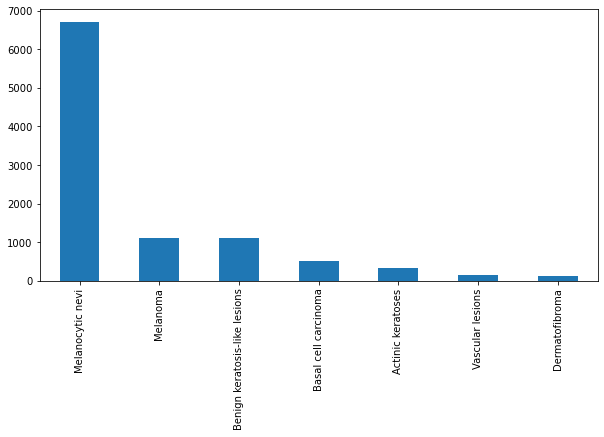

In [4]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [5]:
tile_df['image'] = tile_df['path'].map(imread)

In [6]:
# see the image size distribution
tile_df['image'].map(lambda x: x.shape).value_counts()

(450, 600, 3)    10015
Name: image, dtype: int64

In [7]:
train_df, validation_df = train_test_split(tile_df, test_size=0.2)

<AxesSubplot:>

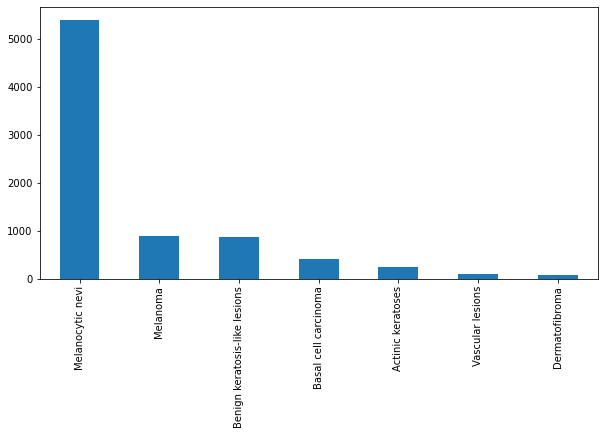

In [8]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
train_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [9]:
# see the image size distribution
train_df['image'].map(lambda x: x.shape).value_counts()

(450, 600, 3)    8012
Name: image, dtype: int64

<AxesSubplot:>

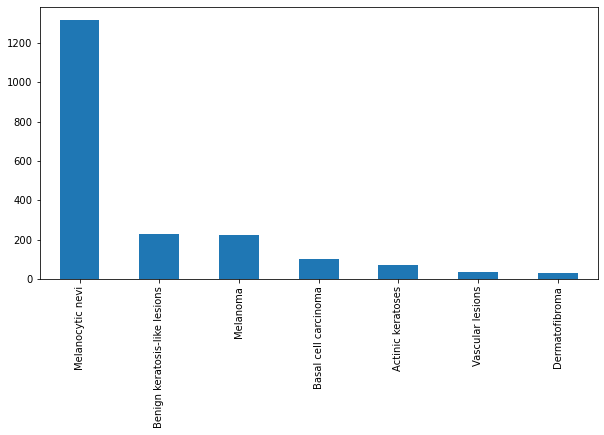

In [10]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
validation_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [11]:
# see the image size distribution
validation_df['image'].map(lambda x: x.shape).value_counts()

(450, 600, 3)    2003
Name: image, dtype: int64

In [12]:
#tile_df[['cell_type_idx', 'cell_type']].sort_values('cell_type_idx').drop_duplicates()

In [13]:
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

In [14]:
#train_df.to_csv('temp.csv')

In [15]:
for i in range(len(train_df)):
    if train_df['cell_type_idx'][i] in [0, 1, 2, 3, 5, 6]: #extend all categories except for nevus
        img_np = train_df['image'][i]
        img = Image.fromarray(img_np.astype('uint8'), 'RGB')
        img2 = img.transpose(Image.ROTATE_90)
        img3 = img.transpose(Image.ROTATE_180)
        img4 = img.transpose(Image.ROTATE_270)

        train_df.loc[len(train_df.index)] = [train_df['image_id'][i],
                                           train_df['cell_type'][i],
                                           train_df['cell_type_idx'][i],
                                           train_df['path'][i],
                                           np.array(img2)]

        train_df.loc[len(train_df.index)] = [train_df['image_id'][i],
                                           train_df['cell_type'][i],
                                           train_df['cell_type_idx'][i],
                                           train_df['path'][i],
                                           np.array(img3)]

        train_df.loc[len(train_df.index)] = [train_df['image_id'][i],
                                           train_df['cell_type'][i],
                                           train_df['cell_type_idx'][i],
                                           train_df['path'][i],
                                           np.array(img4)]

<AxesSubplot:>

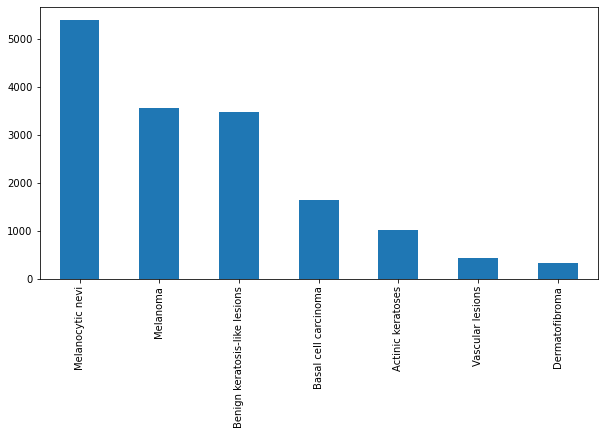

In [16]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
train_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [17]:
# see the image size distribution
train_df['image'].map(lambda x: x.shape).value_counts()

(450, 600, 3)    10636
(600, 450, 3)     5248
Name: image, dtype: int64

**ResNET50 initialization**

In [18]:
model_conv = models.resnet50(pretrained=True)
num_ftrs = model_conv.fc.in_features
model_conv.fc = torch.nn.Linear(num_ftrs, 7)
print(model_conv.fc)
model_conv.to(device)

Linear(in_features=2048, out_features=7, bias=True)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Training and validation set**

In [19]:
class DatasetCustom(torch.utils.data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, df, transform=None):
        """Initialization"""
        self.df = df
        self.transform = transform

    def __len__(self):
        """Denotes the total number of samples"""
        return len(self.df)

    def __getitem__(self, index):
        """Generates one sample of data"""
        # Load data and get label
        img = Image.open(self.df['path'][index])
        label = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            img = self.transform(img)

        return img, label

In [20]:
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

#train_df.to_csv('temp1.csv')
#validation_df.to_csv('temp2.csv')

In [21]:
batch_size = 16
batch_size_test = 16
'''
composed = trf.Compose([trf.RandomHorizontalFlip(), trf.RandomVerticalFlip(), trf.CenterCrop(300),  trf.ToTensor(),
                        trf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
  , trf.ColorJitter(contrast=(1.4, 1.5))
  trf.ColorJitter(contrast=(1.4, 1.5)), trf.Resize(300) , trf.RandomCrop(224)
  ----last-----
composed = trf.Compose([trf.ColorJitter(contrast=(1.4, 1.5)), trf.Resize(300), trf.CenterCrop(224), trf.ToTensor(),
                        trf.Normalize(mean=[0.73, 0.51, 0.53], std=[0.15, 0.17, 0.19])])
'''

composed = trf.Compose([trf.Resize(300), trf.CenterCrop(224), trf.ToTensor(),
                        trf.Normalize(mean=[0.73, 0.51, 0.53], std=[0.15, 0.17, 0.19])])

# Define the training set using the table train_df and using our defined transitions (composed)
training_set = DatasetCustom(train_df, transform=composed)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)

# Same for the validation set:
validation_set = DatasetCustom(validation_df, transform=composed)
validation_generator = torch.utils.data.DataLoader(validation_set, batch_size = batch_size_test, shuffle=True)

# Same for the test set:
test_set = DatasetCustom(validation_df, transform=composed)
test_generator = torch.utils.data.SequentialSampler(test_set)

**Training and testing the model**
Now we have to define the optimizer we want to use. In this case, it will be an Adam optimizer with a learning rate of 1e−61e−6.
The loss function that we will use is CrossEntropyLoss. This is the typical one chosen for multiclass classification problems.

In [22]:
optimizer = torch.optim.Adam(model_conv.parameters(), lr=1e-6)
criterion = torch.nn.CrossEntropyLoss()

max_epochs = 100
iteration_train_max = 50
trainings_error,  validation_error, training_accuracy, validation_accuracy = [], [], [], []

for epoch in range(max_epochs):
    correct_train = 0
    iteration_train = 0
    trainings_error_tmp = []
    print('epoch: {}/{}'.format(epoch + 1, max_epochs))
    print(training_generator)
    model_conv.train()
    for data_sample, y in training_generator:
        data_gpu, y_gpu = data_sample.to(device), y.to(device) #GPU
        output = model_conv(data_gpu) #Calculate output of the net
        err = criterion(output, y_gpu) #Calculate the error of the prediction
        trainings_error_tmp.append(err.item()) #Append error to a temp list
        err.backward() #Backpropagation
        optimizer.step() #Optimizer

        result = torch.argmax(output, dim=1) #Calculate result using ARGMAX
        correct_train += (result == y_gpu).sum() #Calculate correct prediction for each step in epoch

        iteration_train += 1
        if iteration_train >= iteration_train_max:
            iteration_train = 0
            mean_trainings_error = np.mean(trainings_error_tmp) #Calculate the error mean for this epoch
            trainings_error.append(mean_trainings_error) #Append the error mean to a list

            #Calculate training accuracy for each epoch
            #accuracy_train = correct_train/(training_generator.__len__()*batch_size)
            accuracy_train = correct_train/(iteration_train_max*batch_size)
            training_accuracy.append(accuracy_train.item()*100)
            break

    with torch.set_grad_enabled(False):
        correct_val = 0
        validation_error_tmp = []
        model_conv.eval()
        for data_sample, y in validation_generator:
            data_gpu, y_gpu = data_sample.to(device), y.to(device) #GPU
            output = model_conv(data_gpu) #Calculate output of the net
            err = criterion(output, y_gpu) #Calculate the error
            validation_error_tmp.append(err.item()) #Append error to a temp list
            result = torch.argmax(output, dim=1) #Calculate result using ARGMAX
            correct_val += (result == y_gpu).sum() #Calculate correct prediction for each step in epoch

        #Calculate validation accuracy for each epoch
        accuracy_val = correct_val/(validation_generator.__len__()*batch_size_test)
        validation_accuracy.append(accuracy_val.item()*100)

        #Calculate validation error for each epoch
        mean_val_error = np.mean(validation_error_tmp)
        validation_error.append(mean_val_error)

    print("TRAIN ERR: {:.3f}, TRAIN ACC: {:.3f}%".format(mean_trainings_error, accuracy_train*100))
    print("VALID ERR: {:.3f}, VALID ACC: {:.3f}%".format(mean_val_error, accuracy_val*100))

epoch: 1/100
TRAIN ERR: 1.887, TRAIN ACC: 24.875%
VALID ERR: 1.865, VALID ACC: 25.298%
epoch: 2/100
TRAIN ERR: 1.743, TRAIN ACC: 40.875%
VALID ERR: 1.659, VALID ACC: 51.091%
epoch: 3/100
TRAIN ERR: 1.544, TRAIN ACC: 53.625%
VALID ERR: 1.415, VALID ACC: 57.887%
epoch: 4/100
TRAIN ERR: 1.411, TRAIN ACC: 53.000%
VALID ERR: 1.255, VALID ACC: 60.119%
epoch: 5/100
TRAIN ERR: 1.230, TRAIN ACC: 58.000%
VALID ERR: 1.107, VALID ACC: 63.046%
epoch: 6/100
TRAIN ERR: 1.172, TRAIN ACC: 60.250%
VALID ERR: 0.982, VALID ACC: 65.923%
epoch: 7/100
TRAIN ERR: 1.104, TRAIN ACC: 59.500%
VALID ERR: 0.861, VALID ACC: 71.329%
epoch: 8/100
TRAIN ERR: 1.055, TRAIN ACC: 62.375%
VALID ERR: 0.838, VALID ACC: 71.379%
epoch: 9/100
TRAIN ERR: 0.952, TRAIN ACC: 68.875%
VALID ERR: 0.743, VALID ACC: 73.958%
epoch: 10/100
TRAIN ERR: 0.913, TRAIN ACC: 69.125%
VALID ERR: 0.711, VALID ACC: 75.298%
epoch: 11/100
TRAIN ERR: 0.848, TRAIN ACC: 70.625%
VALID ERR: 0.713, VALID ACC: 75.149%
epoch: 12/100
TRAIN ERR: 0.813, TRAIN ACC

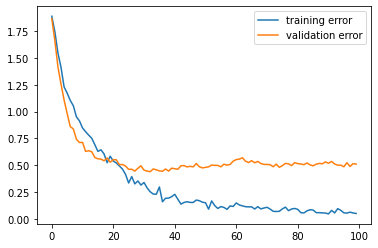

In [23]:
fig = plt.figure()
plt.plot(trainings_error, label = 'training error')
plt.plot(validation_error, label = 'validation error')
plt.legend()
plt.show()
fig.savefig('train{}h{}.{}.png'.format(date, timeh, timem))

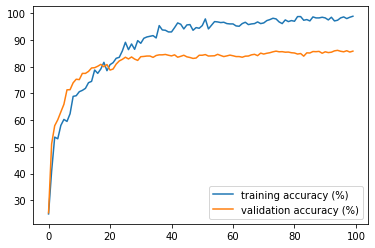

In [24]:
fig = plt.figure()
plt.plot(training_accuracy, label = 'training accuracy (%)')
plt.plot(validation_accuracy, label = 'validation accuracy (%)')
plt.legend()
plt.show()
fig.savefig('test{}h{}.{}.png'.format(date, timeh, timem))

**Testing the model**

In [25]:
model_conv.eval()
result_test, label_test = [], []
for i in test_generator:
    data_sample, y = test_set.__getitem__(i)
    data_gpu = data_sample.unsqueeze(0).to(device)
    output = model_conv(data_gpu)
    result = torch.argmax(output)
    result_test.append(result.item())
    label_test.append(y.item())
correct_results = np.array(result_test)==np.array(label_test)
sum_correct = np.sum(correct_results)
accuracy = sum_correct/test_generator.__len__()
print("Test accuracy: {:.3f}%".format(accuracy*100))

Test accuracy: 86.370%


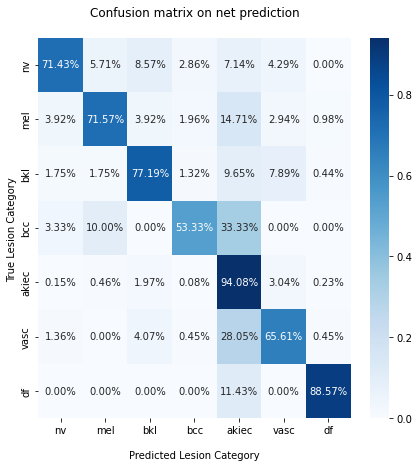

In [26]:
fig = plt.figure(figsize = (7,7))
cf_matrix = confusion_matrix(label_test, result_test, normalize='true')
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='.2%', xticklabels=lesion_type_dict, yticklabels=lesion_type_dict)
ax.set_title('Confusion matrix on net prediction\n')
ax.set_xlabel('\nPredicted Lesion Category')
ax.set_ylabel('True Lesion Category ')
fig.savefig('CONFUSION{}h{}.{}.png'.format(date, timeh, timem))

In [27]:
torch.save(model_conv, '../temp1')